# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


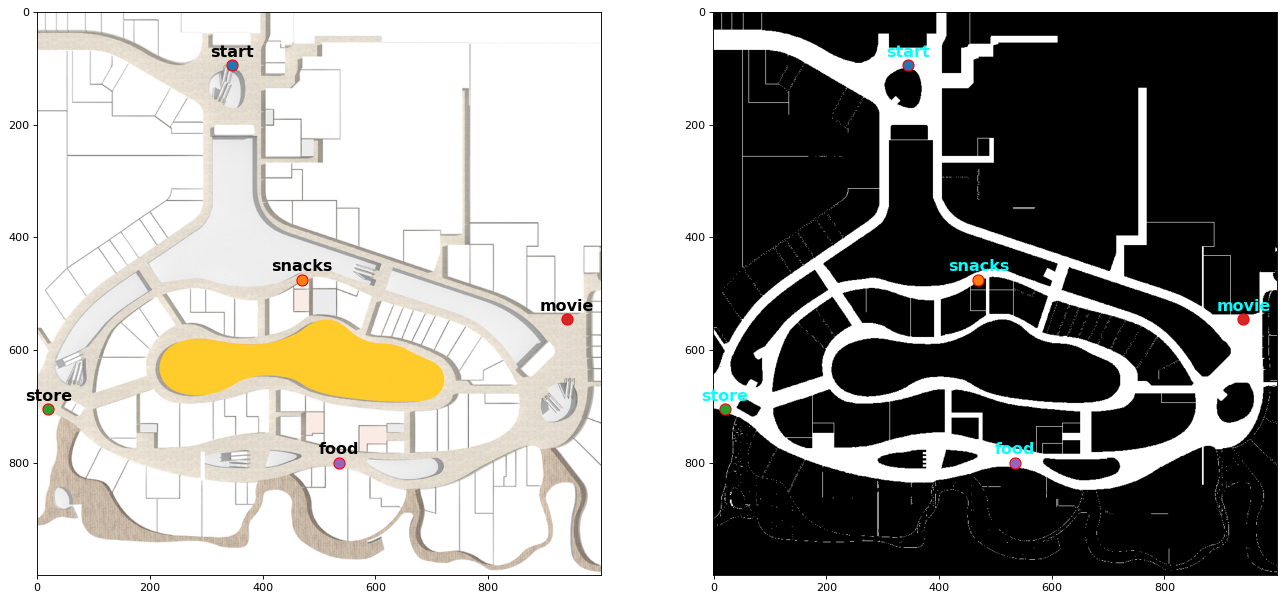

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [4]:
import time
import heapq
from matplotlib.colors import LinearSegmentedColormap
import itertools

In [5]:
def astar_planning(grid_map, start, goal, map_resolution=0.2):
    """
    A* planning algorithm for path finding
    
    Args:
        grid_map: 2D numpy array, free space is 255, obstacles are 0
        start: [x, y] starting position
        goal: [x, y] goal position
        map_resolution: resolution of the map (meters per cell)
        
    Returns:
        path: list of [x, y] positions from start to goal
        cost: total cost of the path in meters
        visited: set of all cells visited during planning
        runtime: execution time in seconds
    """
    # Define neighbors in 8 directions
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]
    # Set the movement cost as required: 0.2m for straight line movement and 0.282m for diagonal movement
    neighbor_costs = [0.2, 0.2, 0.2, 0.2, 0.282, 0.282, 0.282, 0.282]
    
    start_node = tuple(start)
    goal_node = tuple(goal)
    
    open_set = []
    closed_set = set()
    visited = set()
    
    # Record g value and parent node
    g_score = {start_node: 0}
    parent = {}
    
    # Calculate the heuristic function (Euclidean distance)
    def heuristic(a, b):
        return map_resolution * np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    
    # Add the starting point to the open set
    heapq.heappush(open_set, (heuristic(start_node, goal_node), 0, start_node))
    
    # Start timing
    start_time = time.time()
    
    while open_set:
        # Get the node with the smallest f value
        _, current_g, current = heapq.heappop(open_set)
        
        # Add to visit set
        visited.add(current)
        
        # If reach the target
        if current == goal_node:
            # Rebuild the path
            path = []
            while current in parent:
                path.append(list(current))
                current = parent[current]
            path.append(list(start_node))
            path.reverse()
            
            runtime = time.time() - start_time
            return path, g_score[goal_node], visited, runtime
        
        # Add to closed set
        closed_set.add(current)
        
        # Check for all the neighbors
        for i, (dx, dy) in enumerate(neighbors):
            neighbor = (current[0] + dx, current[1] + dy)
            
            # Skip points outside the boundary
            if (neighbor[0] < 0 or neighbor[0] >= grid_map.shape[0] or 
                neighbor[1] < 0 or neighbor[1] >= grid_map.shape[1]):
                continue
            
            # Skip the point over obstacles or already in the closed set
            if grid_map[neighbor[0], neighbor[1]] == 0 or neighbor in closed_set:
                continue
            
            # For diagonal moves, check if both adjacent cells are free
            # Diagonal movement
            if i >= 4:  
                if (grid_map[current[0] + dx, current[1]] == 0 or 
                    grid_map[current[0], current[1] + dy] == 0):
                    continue
            
            # Calculate temporary g value
            tentative_g = g_score[current] + neighbor_costs[i]
            
            # If find better path
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                # Update the neighbor imformation
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic(neighbor, goal_node)
                heapq.heappush(open_set, (f_score, tentative_g, neighbor))
    
    runtime = time.time() - start_time
    return None, float('inf'), visited, runtime

In [6]:
def dijkstra_planning(grid_map, start, goal, map_resolution=0.2):
    """
    Dijkstra's algorithm for path finding (A* without heuristic)
    
    Args:
        grid_map: 2D numpy array, free space is 255, obstacles are 0
        start: [x, y] starting position
        goal: [x, y] goal position
        map_resolution: resolution of t he map (meters per cell)
        
    Returns:
        path: list of [x, y] positions from start to goal
        cost: total cost of the path in meters
        visited: set of all cells visited during planning
        runtime: execution time in seconds
    """
    # Define neighbors in 8 directions
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]
    # Set the movement cost as required: 0.2m for straight line movement and 0.282m for diagonal movement
    neighbor_costs = [0.2, 0.2, 0.2, 0.2, 0.282, 0.282, 0.282, 0.282]
    
    start_node = tuple(start)
    goal_node = tuple(goal)
    
    open_set = []
    closed_set = set()
    visited = set()
    
    g_score = {start_node: 0}
    parent = {}
    
    # Add the starting point to the open set
    # main change: no more heuristics
    # Only use the g value (cost from the starting point to the current point) as the priority
    heapq.heappush(open_set, (0, 0, start_node))  # (priority, g_score, node)
    
    start_time = time.time()
    
    while open_set:
        # Get the node with the lowest priority
        _, current_g, current = heapq.heappop(open_set)
        
        visited.add(current)
        
        # If reach the target
        if current == goal_node:
            # Rebuild the path
            path = []
            while current in parent:
                path.append(list(current))
                current = parent[current]
            path.append(list(start_node))
            path.reverse()
            
            runtime = time.time() - start_time
            return path, g_score[goal_node], visited, runtime
        
        closed_set.add(current)
        
        # Check for all the neighbors
        for i, (dx, dy) in enumerate(neighbors):
            neighbor = (current[0] + dx, current[1] + dy)
            
            # Skip points outside the boundary
            if (neighbor[0] < 0 or neighbor[0] >= grid_map.shape[0] or 
                neighbor[1] < 0 or neighbor[1] >= grid_map.shape[1]):
                continue
            
            # Skip the point over obstacles or already in the closed set
            if grid_map[neighbor[0], neighbor[1]] == 0 or neighbor in closed_set:
                continue
            
            # For diagonal moves, check if both adjacent cells are free
            # Diagonal movement
            if i >= 4:  
                if (grid_map[current[0] + dx, current[1]] == 0 or 
                    grid_map[current[0], current[1] + dy] == 0):
                    continue
            
            # Calculate temporary g value
            tentative_g = g_score[current] + neighbor_costs[i]
            
            # If find better path
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                # Update the neighbor imformation
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                
                # another major change: Prioritization uses only g-values, not f-values ​​anymore
                priority = tentative_g  # Do not add heuristic values
                heapq.heappush(open_set, (priority, tentative_g, neighbor))
    
    runtime = time.time() - start_time
    return None, float('inf'), visited, runtime


In [7]:
def greedy_best_first_search(grid_map, start, goal, map_resolution=0.2):
    """
    Greedy Best First Search algorithm for path finding (只使用启发式函数)
    
    Args:
        grid_map: 2D numpy array, free space is 255, obstacles are 0
        start: [x, y] starting position
        goal: [x, y] goal position
        map_resolution: resolution of the map (meters per cell)
        
    Returns:
        path: list of [x, y] positions from start to goal
        cost: total cost of the path in meters
        visited: set of all cells visited during planning
        runtime: execution time in seconds
    """
    # Define neighbors in 8 directions
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]
    # Set the movement cost as required: 0.2m for straight line movement and 0.282m for diagonal movement
    neighbor_costs = [0.2, 0.2, 0.2, 0.2, 0.282, 0.282, 0.282, 0.282]
    
    start_node = tuple(start)
    goal_node = tuple(goal)
    
    open_set = []
    closed_set = set()
    visited = set()
    
    g_score = {start_node: 0}
    parent = {}
    
    # Calculate the heuristic function (Euclidean distance)
    def heuristic(a, b):
        return map_resolution * np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    
    # Add the starting point to the open set
    # Main change: Priority is determined only by the heuristic function
    # The second parameter (0) is the g value, which is still retained but not used for priority calculation
    heapq.heappush(open_set, (heuristic(start_node, goal_node), 0, start_node))
    
    # Start timing
    start_time = time.time()
    
    while open_set:
        # Get the node with the smallest f value
        _, current_g, current = heapq.heappop(open_set)
        
        # Add to visit set
        visited.add(current)
        
        # If reach the target
        if current == goal_node:
            # Rebuild the path
            path = []
            while current in parent:
                path.append(list(current))
                current = parent[current]
            path.append(list(start_node))
            path.reverse()
            
            # Calculate the actual cost of the path
            actual_cost = g_score[goal_node]
            
            runtime = time.time() - start_time
            return path, actual_cost, visited, runtime
        
        # Add to closed set
        closed_set.add(current)
        
        # Check for all the neighbors
        for i, (dx, dy) in enumerate(neighbors):
            neighbor = (current[0] + dx, current[1] + dy)
            
            # Skip points outside the boundary
            if (neighbor[0] < 0 or neighbor[0] >= grid_map.shape[0] or 
                neighbor[1] < 0 or neighbor[1] >= grid_map.shape[1]):
                continue
            
            # Skip the point over obstacles or already in the closed set
            if grid_map[neighbor[0], neighbor[1]] == 0 or neighbor in closed_set:
                continue
            
            # For diagonal moves, check if both adjacent cells are free
            # Diagonal movement
            if i >= 4:
                if (grid_map[current[0] + dx, current[1]] == 0 or 
                    grid_map[current[0], current[1] + dy] == 0):
                    continue
            
            # Calculate temporary g value
            # Still need to calculate actual cost, but not used for priority
            tentative_g = g_score[current] + neighbor_costs[i]
            
            # No need to compare g values ​​to decide whether to update
            # Just make sure the node has not been visited or is not in the open set
            if neighbor not in closed_set and neighbor not in [n[2] for n in open_set]:
                # Update the neighbor imformation
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                
                # Major change: Priority only uses heuristic values, completely ignoring g values
                priority = heuristic(neighbor, goal_node)
                heapq.heappush(open_set, (priority, tentative_g, neighbor))
            
            
    runtime = time.time() - start_time
    return None, float('inf'), visited, runtime


In [8]:
def compute_all_pairwise_paths(grid_map, locations, map_resolution=0.2, algorithm = "Astar"):
    """
    Compute paths between all pairs of locations
    
    Args:
        grid_map: 2D numpy array, free space is 255, obstacles are 0
        locations: dict of location names and [x, y] coordinates
        map_resolution: resolution of the map (meters per cell)
        
    Returns:
        all_paths: dict of paths between locations
        distance_matrix: matrix of distances between all locations
        visited_cells: dict of visited cells for each path
        performance: dict of performance metrics
    """
    location_names = list(locations.keys())
    n_locations = len(location_names)
    
    all_paths = {}
    visited_cells = {}
    performance = {}
    distance_matrix = np.zeros((n_locations, n_locations))
    
    print("\nCompute paths between all pairs of locations...")
    
    start_time_total = time.time()
    
    for i in range(n_locations):
        for j in range(n_locations):
            if i == j:
                distance_matrix[i, j] = 0
                continue
                
            loc1 = location_names[i]
            loc2 = location_names[j]
            
            path_key = f"{loc1}_to_{loc2}"
            
            print(f"Calculate the {path_key} path...")
            
            if algorithm == "Astar":
            # Use A* calculate the path
                path, cost, visited, runtime = astar_planning(
                    grid_map, locations[loc1], locations[loc2], map_resolution)
            elif algorithm == "Dijkstra":
                path, cost, visited, runtime = dijkstra_planning(
                    grid_map, locations[loc1], locations[loc2], map_resolution)
            elif algorithm == "GBFS":
                path, cost, visited, runtime = greedy_best_first_search(
                    grid_map, locations[loc1], locations[loc2], map_resolution)
            else:
                print("Sorry, there is no such algorithm here, the default is to execute the Astar algorithm for you\n")
                path, cost, visited, runtime = astar_planning(
                    grid_map, locations[loc1], locations[loc2], map_resolution)
            
            # Result
            all_paths[path_key] = path
            visited_cells[path_key] = visited
            
            # Distance
            distance_matrix[i, j] = cost
            
            # Performance
            performance[path_key] = {
                'runtime': runtime,
                'visited_cells': len(visited),
                'path_length': len(path) if path else 0,
                'path_cost': cost
            }
    
    total_time = time.time() - start_time_total
    
    #  Overall performance metrics
    performance['total'] = {
        'runtime': total_time,
        'average_runtime': total_time / (n_locations * (n_locations - 1)),
        'paths_computed': n_locations * (n_locations - 1)
    }
    
    return all_paths, distance_matrix, visited_cells, performance


In [9]:
def solve_open_tsp_bruteforce(distance_matrix, start_index=0):
    """
    Solve the Open Traveling Salesman Problem using brute force (no need to return to the starting point)
    
    Args:
        distance_matrix: Distance matrix
        start_index: Starting point index
        
    Returns:
        best_route: The best route (list of indices)
        best_distance: The total distance of the best route
    """
    n = distance_matrix.shape[0]
    
    # All position indices, excluding the starting point
    other_indices = [i for i in range(n) if i != start_index]
    
    # Initialize the best route and distance
    best_route = None
    best_distance = float('inf')
    
    # Generate all possible permutations
    for perm in itertools.permutations(other_indices):
        # Full route: Starting point -> All other points
        route = [start_index] + list(perm)
        
        # Calculate total distance
        distance = 0
        for i in range(len(route) - 1):
            distance += distance_matrix[route[i], route[i+1]]
        
        # Update the best route
        if distance < best_distance:
            best_distance = distance
            best_route = route
    
    return best_route, best_distance


In [10]:
def build_tsp_route_path(route_indices, location_names, all_paths):
    """
    Build the full path for the TSP route
    
    Args:
        route_indices: List of route indices
        location_names: List of location names
        all_paths: Paths between all pairs of locations
        
    Returns:
        full_path: List of full path points
    """
    full_path = []
    
    # Connect all sub-paths
    for i in range(len(route_indices) - 1):
        from_idx = route_indices[i]
        to_idx = route_indices[i+1]
        
        from_name = location_names[from_idx]
        to_name = location_names[to_idx]
        
        # Get the sub-path
        path_key = f"{from_name}_to_{to_name}"
        if path_key in all_paths and all_paths[path_key]:
            # Skip the starting point for sub-paths that are not the first (to avoid repetition)
            if i > 0:
                sub_path = all_paths[path_key][1:]
            else:
                sub_path = all_paths[path_key]
            
            full_path.extend(sub_path)
    
    return full_path


In [11]:
def visualize_open_tsp_solution(floor_plan, locations, route_names, full_path, distance):
    """
    Visualize the Open TSP solution
    
    Args:
        floor_plan: Map image
        locations: Dictionary of locations
        route_names: Sequence of location names for the route
        full_path: List of full path points
        distance: Total distance
    """
    plt.figure(figsize=(15, 12), dpi=80)
    
    # Draw the map
    plt.imshow(floor_plan)
    
    # Plot location points
    plot_locations(locations)
    
    # Draw the full path
    if full_path:
        x_coords = [p[0] for p in full_path]
        y_coords = [p[1] for p in full_path]
        plt.plot(x_coords, y_coords, '-b', linewidth=3)
    
    # Add direction arrows to the path
    if full_path and len(full_path) > 1:
        arrow_indices = np.linspace(0, len(full_path) - 1, min(20, len(full_path)), dtype=int)
        for i in arrow_indices:
            if i < len(full_path) - 1:
                dx = full_path[i+1][0] - full_path[i][0]
                dy = full_path[i+1][1] - full_path[i][1]
                # Normalize and shorten the arrow
                magnitude = np.sqrt(dx**2 + dy**2)
                if magnitude > 0:
                    dx = dx / magnitude * 20
                    dy = dy / magnitude * 20
                    plt.arrow(full_path[i][0], full_path[i][1], dx, dy, 
                             head_width=10, head_length=10, fc='red', ec='red')
    
    # Add route sequence labels
    route_str = ' → '.join(route_names)
    title = f"Task 1: Shortest Path - Total Distance: {distance:.2f}m\nRoute: {route_str}"
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [12]:
def print_distance_matrix(distance_matrix, location_names):
    """
    Print the formatted distance matrix
    
    Args:
        distance_matrix: 2D numpy array of distances
        location_names: List of location names
    """
    print("\nShortest Distance Matrix (Unit: meters):")
    # Print header
    print(f"{'':12}", end="")
    for name in location_names:
        print(f"{name:12}", end="")
    print()
    
    # Print rows
    for i, name in enumerate(location_names):
        print(f"{name:12}", end="")
        for j in range(len(location_names)):
            if distance_matrix[i][j] == float('inf'):
                print(f"{'Unreachable':12}", end="")
            else:
                print(f"{distance_matrix[i][j]:.2f}m{'':<7}", end="")
        print()


In [13]:
def run_task1_open_tsp(algorithm):
    """Run Task 1: Open TSP (visit all locations starting from 'start', no need to return to the start)"""
    print("start task1: use " + algorithm + " to calculate the shortest path from start to all locations...")
    
    # Compute paths between all pairs of locations
    all_paths, distance_matrix, visited_cells, performance = compute_all_pairwise_paths(
        grid_map, locations, MAP_RES, algorithm)
    
    # Store the path computation time
    pathfinding_time = performance['total']['runtime']
    
    # Print distance matrix
    location_names = list(locations.keys())
    print_distance_matrix(distance_matrix, location_names)
    
    # Print performance metrics
    print("\nPerformance metrics for each path:")
    for path_key, metrics in performance.items():
        if path_key != 'total':
            print(f"{path_key}:")
            print(f"  Runtime: {metrics['runtime']:.4f} seconds")
            print(f"  Visited cells: {metrics['visited_cells']}")
            print(f"  Path length: {metrics['path_length']} cells")
            print(f"  Path distance: {metrics['path_cost']:.2f} meters")
    
    print(f"\nPathfinding computation time: {pathfinding_time:.4f} seconds")
    print(f"Average time per path computation: {performance['total']['average_runtime']:.4f} seconds")
    
    # Solve Open TSP using brute force
    print("\nSolving Open TSP problem using brute force...")
    start_index = location_names.index('start')
    
    start_time = time.time()
    route, distance = solve_open_tsp_bruteforce(distance_matrix, start_index)
    solve_time = time.time() - start_time
    
    # Calculate total time (pathfinding + TSP solving)
    total_time = pathfinding_time + solve_time
    
    # Convert indices to location names
    route_names = [location_names[idx] for idx in route]
    
    # Build the full path
    full_path = build_tsp_route_path(route, location_names, all_paths)
    
    # Print results
    print("\nTask 1 result:")
    print(f"The shortest path: {' → '.join(route_names)}")
    print(f"Total travelled distance: {distance:.2f} meters")
    print(f"Total combined time: {total_time:.4f} seconds")
    
    # Calculate the total visited cells
    visited_count = 0
    for i in range(len(route) - 1):
        from_name = location_names[route[i]]
        to_name = location_names[route[i+1]]
        path_key = f"{from_name}_to_{to_name}"
        if path_key in visited_cells:
            visited_count += len(visited_cells[path_key])
    
    print(f"All the cells visited: {visited_count}")
    
    # Visualize the result
    visualize_open_tsp_solution(floor_plan, locations, route_names, full_path, distance)
    
    return all_paths, distance_matrix, route_names, distance, visited_cells


start task1: use GBFS to calculate the shortest path from start to all locations...

Compute paths between all pairs of locations...
Calculate the start_to_snacks path...
Calculate the start_to_store path...
Calculate the start_to_movie path...
Calculate the start_to_food path...
Calculate the snacks_to_start path...
Calculate the snacks_to_store path...
Calculate the snacks_to_movie path...
Calculate the snacks_to_food path...
Calculate the store_to_start path...
Calculate the store_to_snacks path...
Calculate the store_to_movie path...
Calculate the store_to_food path...
Calculate the movie_to_start path...
Calculate the movie_to_snacks path...
Calculate the movie_to_store path...
Calculate the movie_to_food path...
Calculate the food_to_start path...
Calculate the food_to_snacks path...
Calculate the food_to_store path...
Calculate the food_to_movie path...

Shortest Distance Matrix (Unit: meters):
            start       snacks      store       movie       food        
start       

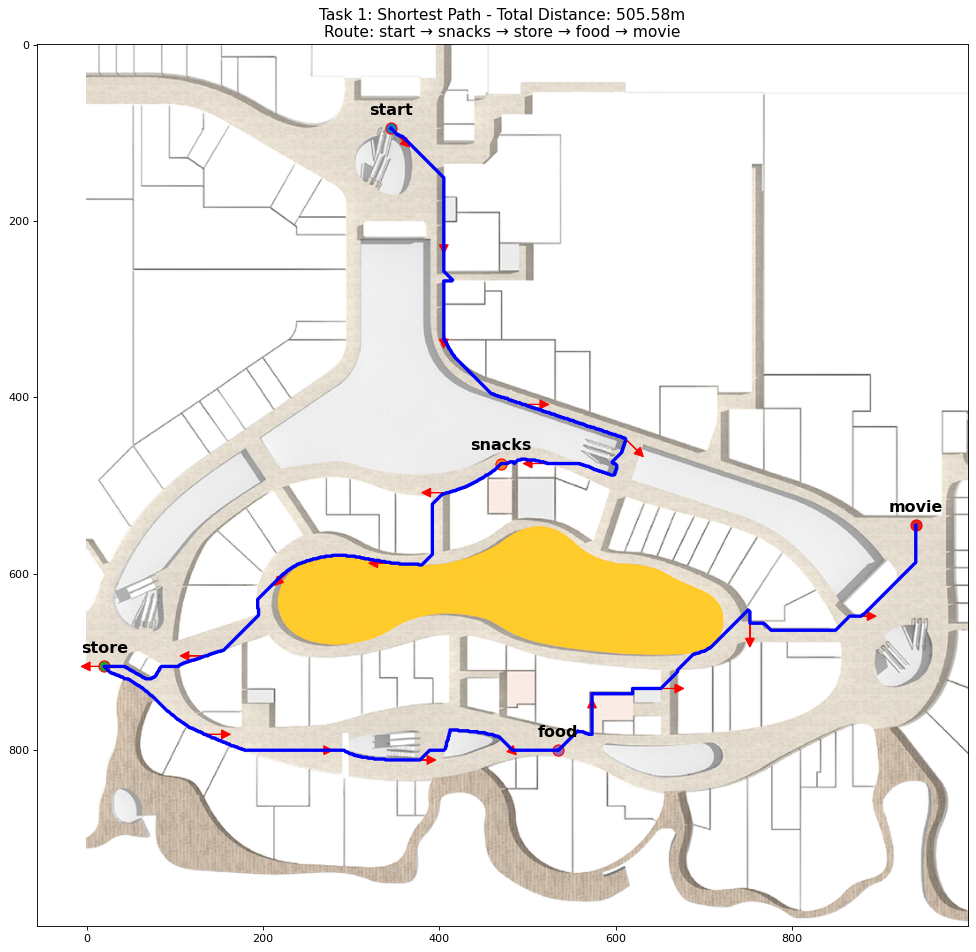

In [24]:
if __name__ == "__main__":
    # algorithm: Astar, Dijkstra, GBFS
    all_paths, distance_matrix, route, distance, visited_cells = run_task1_open_tsp("GBFS")

## Task 2

In [15]:
def solve_tsp_bruteforce(distance_matrix, start_index=0):
    """
    Solve the TSP problem using brute force (Task 2)
    
    Args:
        distance_matrix: Distance matrix
        start_index: Starting point index
        
    Returns:
        best_route: The best route (list of indices)
        best_distance: The total distance of the best route
        runtime: Computation time
    """
    n = distance_matrix.shape[0]
    
    # All position indices, excluding the starting point
    other_indices = [i for i in range(n) if i != start_index]
    
    # Initialize the best route and distance
    best_route = None
    best_distance = float('inf')
    
    # Start timing
    start_time = time.time()
    
    # Enumerate all possible permutations (4! = 24 permutations)
    all_permutations = list(itertools.permutations(other_indices))
    total_perms = len(all_permutations)
    
    for i, perm in enumerate(all_permutations):
        # Complete route: start point -> intermediate points -> start point
        route = [start_index] + list(perm) + [start_index]
        
        # Calculate total distance
        distance = 0
        for j in range(len(route) - 1):
            distance += distance_matrix[route[j], route[j+1]]
        
        # Update the best route
        if distance < best_distance:
            best_distance = distance
            best_route = route
            
        # Print progress
        if (i+1) % 6 == 0 or i == total_perms-1:  # Print every 6 permutations
            print(f"Brute force progress: {i+1}/{total_perms} ({(i+1)/total_perms*100:.1f}%)")
    
    runtime = time.time() - start_time
    
    return best_route, best_distance, runtime



In [16]:
def solve_tsp_nearest_neighbor(distance_matrix, start_index=0):
    """
    Solve the TSP problem using the Nearest Neighbor algorithm (Task 2)
    
    Args:
        distance_matrix: Distance matrix
        start_index: Starting point index
        
    Returns:
        route: The route (list of indices)
        distance: The total distance of the route
        runtime: Computation time
    """
    n = distance_matrix.shape[0]
    
    # Start timing
    start_time = time.time()
    
    # Initialization
    unvisited = set(range(n))
    unvisited.remove(start_index)
    
    # Start from the starting point
    route = [start_index]
    current = start_index
    total_distance = 0
    
    # Greedily choose the nearest unvisited point
    while unvisited:
        # Find the nearest unvisited point
        next_point = min(unvisited, key=lambda x: distance_matrix[current, x])
        
        # Update route and distance
        route.append(next_point)
        total_distance += distance_matrix[current, next_point]
        
        # Mark the point as visited
        unvisited.remove(next_point)
        current = next_point
    
    # Return to the start point
    route.append(start_index)
    total_distance += distance_matrix[current, start_index]
    
    runtime = time.time() - start_time
    
    return route, total_distance, runtime


In [17]:
def build_tsp_route_path_task2(route_indices, location_names, all_paths):
    """
    Build the full path for the TSP route (Task 2)
    
    Args:
        route_indices: List of route indices
        location_names: List of location names
        all_paths: Paths between all pairs of locations
        
    Returns:
        full_path: List of full path points
    """
    full_path = []
    
    # Connect all sub-paths
    for i in range(len(route_indices) - 1):
        from_idx = route_indices[i]
        to_idx = route_indices[i+1]
        
        from_name = location_names[from_idx]
        to_name = location_names[to_idx]
        
        # Get the sub-path
        path_key = f"{from_name}_to_{to_name}"
        if path_key in all_paths and all_paths[path_key]:
            # If it's not the first sub-path, skip the starting point (to avoid repetition)
            if i > 0:
                sub_path = all_paths[path_key][1:]
            else:
                sub_path = all_paths[path_key]
            
            full_path.extend(sub_path)
    
    return full_path


In [18]:
def visualize_tsp_solution(floor_plan, locations, route_names, full_path, method_name, distance, runtime):
    """
    Visualize the TSP solution (Task 2)
    
    Args:
        floor_plan: Map image
        locations: Dictionary of locations
        route_names: Sequence of route location names
        full_path: List of full path points
        method_name: Method name
        distance: Total distance
        runtime: Computation time
    """
    plt.figure(figsize=(15, 12), dpi=80)
    
    # Draw the map
    plt.imshow(floor_plan)
    
    # Plot location points - Assuming plot_locations is the function defined in Task 1
    # If it's named differently in Task 1, please modify the function call here
    plot_locations(locations)
    
    # Draw the full path
    if full_path:
        x_coords = [p[0] for p in full_path]
        y_coords = [p[1] for p in full_path]
        plt.plot(x_coords, y_coords, '-b', linewidth=3)
    
    # Add direction arrows to the path
    if full_path and len(full_path) > 1:
        arrow_indices = np.linspace(0, len(full_path) - 1, min(30, len(full_path)), dtype=int)
        for i in arrow_indices:
            if i < len(full_path) - 1:
                dx = full_path[i+1][0] - full_path[i][0]
                dy = full_path[i+1][1] - full_path[i][1]
                # Normalize and shorten the arrows
                magnitude = np.sqrt(dx**2 + dy**2)
                if magnitude > 0:
                    dx = dx / magnitude * 15
                    dy = dy / magnitude * 15
                    plt.arrow(full_path[i][0], full_path[i][1], dx, dy, 
                             head_width=8, head_length=10, fc='red', ec='red')
    
    # Add route sequence labels
    route_str = ' → '.join(route_names)
    title = f"Task 2: {method_name}\nTotal Distance: {distance:.2f}m, Computation Time: {runtime:.6f} seconds\nRoute: {route_str}"
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [19]:
def run_task2_tsp(all_paths, distance_matrix, location_names):
    """
    Run Task 2: Traveling Salesman Problem (visit all locations and return to the starting point)
    
    Args:
        all_paths: All paths computed in Task 1
        distance_matrix: Distance matrix
        location_names: List of location names
    """
    print("\nStarting Task 2: Traveling Salesman Problem...")
    print("==============================================")
    
    # Determine the starting point index
    start_index = location_names.index('start')
    
    # Method 1: Brute-force
    print("Method 1: Using Brute-force...")
    bf_route, bf_distance, bf_time = solve_tsp_bruteforce(distance_matrix, start_index)
    
    # Method 2: Nearest Neighbor (Greedy)
    print("Method 2: Using Nearest Neighbor algorithm...")
    nn_route, nn_distance, nn_time = solve_tsp_nearest_neighbor(distance_matrix, start_index)
    
    # Convert indices to location names
    bf_route_names = [location_names[idx] for idx in bf_route]
    nn_route_names = [location_names[idx] for idx in nn_route]
    
    # Build full paths
    bf_full_path = build_tsp_route_path(bf_route, location_names, all_paths)
    nn_full_path = build_tsp_route_path(nn_route, location_names, all_paths)
    
    # Print result comparison
    print("\nTSP Result Comparison:")
    print("==============================================")
    print(f"Method 1 (Brute-force):")
    print(f"  Route: {' → '.join(bf_route_names)}")
    print(f"  Total Distance: {bf_distance:.2f} meters")
    print(f"  Computation Time: {bf_time:.6f} seconds")
    
    print(f"\nMethod 2 (Nearest Neighbor):")
    print(f"  Route: {' → '.join(nn_route_names)}")
    print(f"  Total Distance: {nn_distance:.2f} meters")
    print(f"  Computation Time: {nn_time:.6f} seconds")
    
    # Determine the best method
    if bf_distance <= nn_distance:
        best_method = "Brute-force"
        best_distance = bf_distance
        best_route = bf_route_names
        best_path = bf_full_path
        best_time = bf_time
    else:
        best_method = "Nearest Neighbor"
        best_distance = nn_distance
        best_route = nn_route_names
        best_path = nn_full_path
        best_time = nn_time
    
    print(f"\nBest Method: {best_method}")
    print(f"Shortest Route: {' → '.join(best_route)}")
    print(f"Total Distance: {best_distance:.2f} meters")
    print("==============================================")
    
    # Visualize results of both methods
    visualize_tsp_solution(floor_plan, locations, bf_route_names, bf_full_path, 
                          "Brute-force", bf_distance, bf_time)
    visualize_tsp_solution(floor_plan, locations, nn_route_names, nn_full_path, 
                          "Nearest Neighbor", nn_distance, nn_time)
    
    # Visualize the best solution
    print("\nDisplaying the final shortest route:")
    visualize_tsp_solution(floor_plan, locations, best_route, best_path, 
                          f"Best Method: {best_method}", best_distance, best_time)
    
    return bf_route_names, nn_route_names, bf_distance, nn_distance



Compute paths between all pairs of locations...
Calculate the start_to_snacks path...
Calculate the start_to_store path...
Calculate the start_to_movie path...
Calculate the start_to_food path...
Calculate the snacks_to_start path...
Calculate the snacks_to_store path...
Calculate the snacks_to_movie path...
Calculate the snacks_to_food path...
Calculate the store_to_start path...
Calculate the store_to_snacks path...
Calculate the store_to_movie path...
Calculate the store_to_food path...
Calculate the movie_to_start path...
Calculate the movie_to_snacks path...
Calculate the movie_to_store path...
Calculate the movie_to_food path...
Calculate the food_to_start path...
Calculate the food_to_snacks path...
Calculate the food_to_store path...
Calculate the food_to_movie path...

Starting Task 2: Traveling Salesman Problem...
Method 1: Using Brute-force...
Brute force progress: 6/24 (25.0%)
Brute force progress: 12/24 (50.0%)
Brute force progress: 18/24 (75.0%)
Brute force progress: 24/

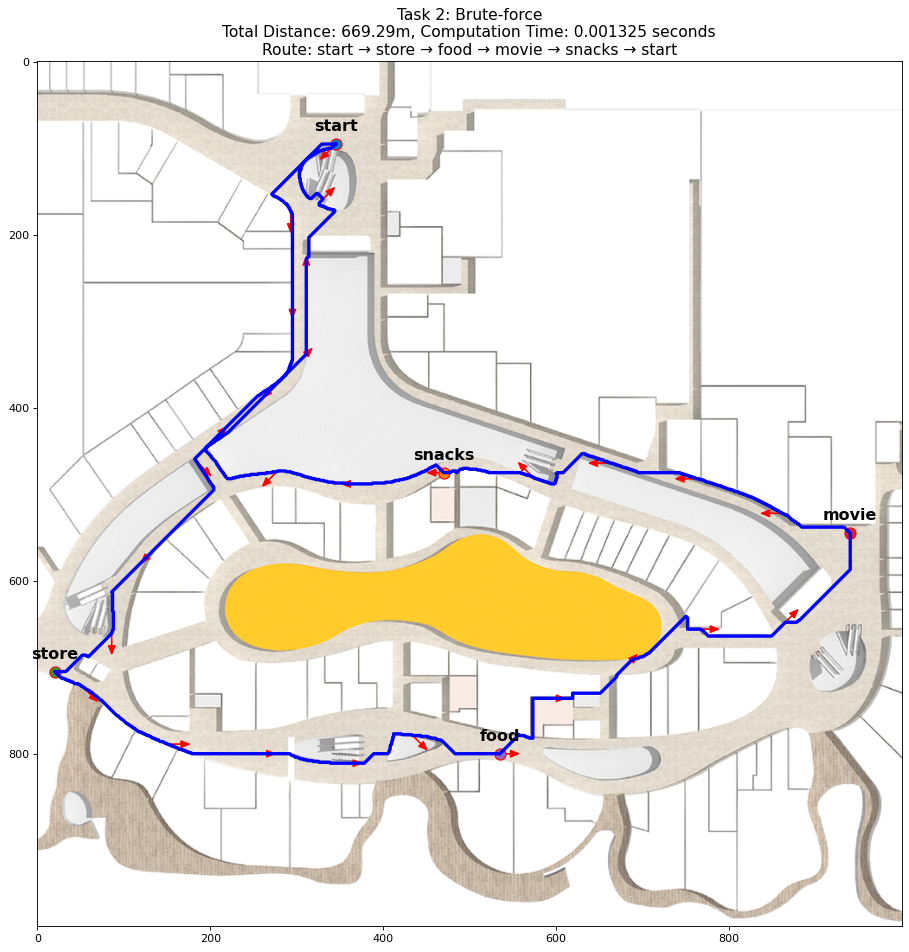

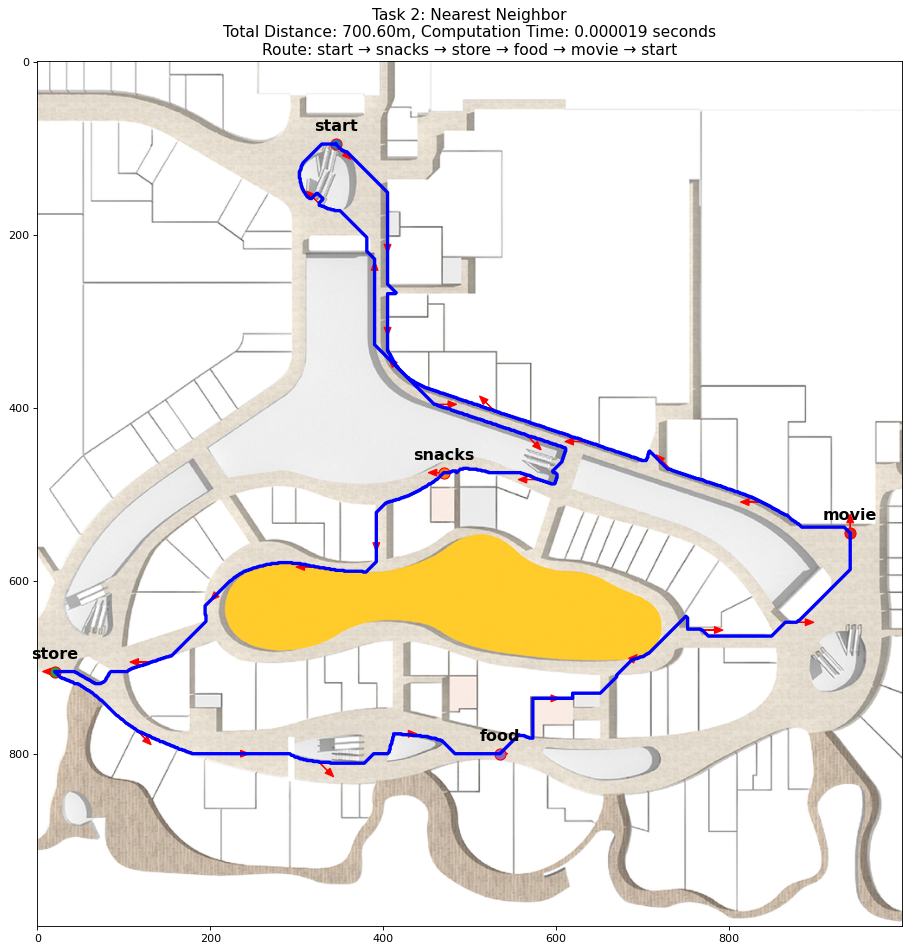


Displaying the final shortest route:


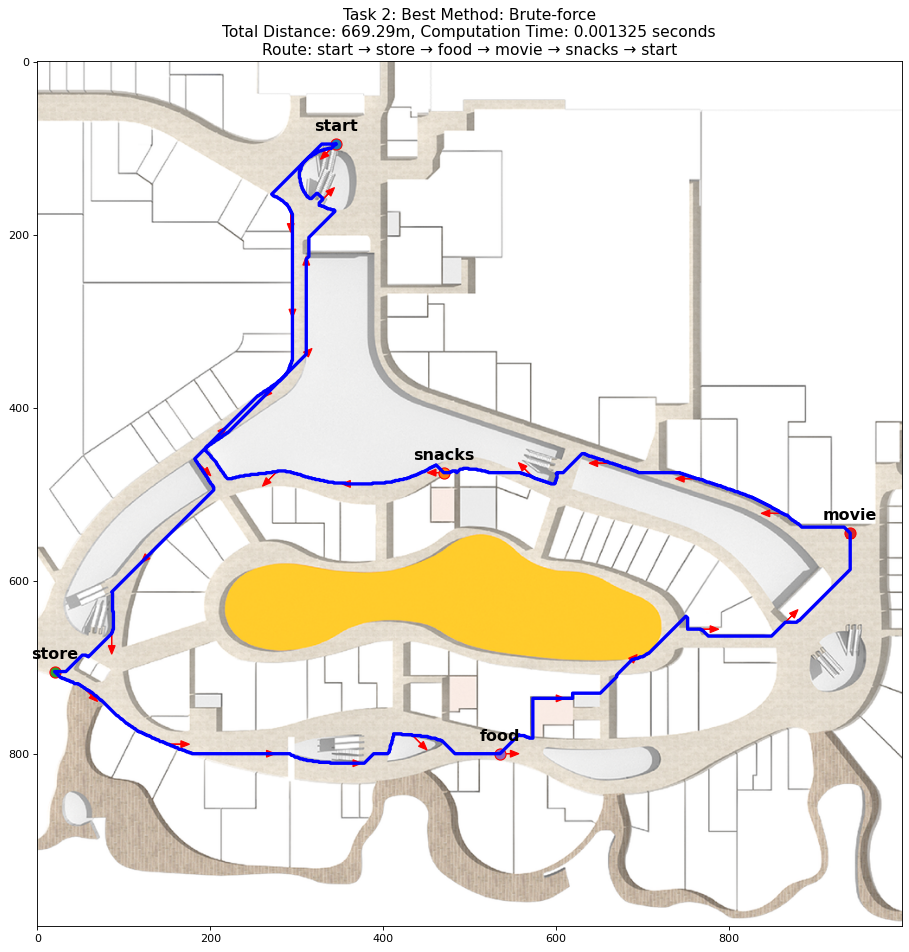

In [25]:
if __name__ == "__main__":
    # Task 1 algorithm: Astar, Dijkstra, GBFS
    # If Task 1 has not been executed, uncomment the following commented code and run this block
    
    # Get all paths and the distance matrix from Task 1
    all_paths, distance_matrix, visited_cells, performance = compute_all_pairwise_paths(
        grid_map, locations, MAP_RES, "GBFS")
    
    # Run Task 2
    location_names = list(locations.keys())
    bf_route, nn_route, bf_distance, nn_distance = run_task2_tsp(all_paths, distance_matrix, location_names)


## Task 3